# Preparing Libraries and Loading Data
## Data is all Divvy usage in 2022

Begin by loading all our data from CSV and concatenating the files together


In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [2]:
#List all the CSV files in trip_data folder, these represent all 2022 ride data
glob.glob('trip_data/*-divvy-*')

['trip_data\\202201-divvy-tripdata.csv',
 'trip_data\\202202-divvy-tripdata.csv',
 'trip_data\\202203-divvy-tripdata.csv',
 'trip_data\\202204-divvy-tripdata.csv',
 'trip_data\\202205-divvy-tripdata.csv',
 'trip_data\\202206-divvy-tripdata.csv',
 'trip_data\\202207-divvy-tripdata.csv',
 'trip_data\\202208-divvy-tripdata.csv',
 'trip_data\\202209-divvy-publictripdata.csv',
 'trip_data\\202210-divvy-tripdata.csv',
 'trip_data\\202211-divvy-tripdata.csv',
 'trip_data\\202212-divvy-tripdata.csv']

In [3]:
#Load all CSV files into a DataFrame and place them into a list ('all_csv')
#Parse the started_at & ended_at columns as date types
all_csv = []
for filename in glob.glob('trip_data/*-divvy-*'):
    print(f'loading: {filename}')
    current_csv = pd.read_csv(filename, parse_dates = ['started_at', 'ended_at'])
    all_csv.append(current_csv)

loading: trip_data\202201-divvy-tripdata.csv
loading: trip_data\202202-divvy-tripdata.csv
loading: trip_data\202203-divvy-tripdata.csv
loading: trip_data\202204-divvy-tripdata.csv
loading: trip_data\202205-divvy-tripdata.csv
loading: trip_data\202206-divvy-tripdata.csv
loading: trip_data\202207-divvy-tripdata.csv
loading: trip_data\202208-divvy-tripdata.csv
loading: trip_data\202209-divvy-publictripdata.csv
loading: trip_data\202210-divvy-tripdata.csv
loading: trip_data\202211-divvy-tripdata.csv
loading: trip_data\202212-divvy-tripdata.csv


In [4]:
#Concat DataFrames from all csv files together
df = pd.concat(all_csv)

In [5]:
#Reset index
#drop=True prevents the new index from being inserted as a column
df = df.reset_index(drop=True)

In [6]:
df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

# Data Exploration

In [7]:
#Number of rows in DF
print(len(df), ' rows')

#Number of columns in DF
print(len(df.columns), ' columns')

5667717  rows
13  columns


In [8]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member


# Data Cleaning
In this section, I review and account for the oddities within the data such as negative ride lengths as well
as taking a look at, and trying to explain, some of the NA values

### Data Cleaning Question 1: 
How many NA values are present?

In [9]:
#Viewing the number of NA values, we can see that the start & end station name and ID cols have around 14-15% NA values
na_counts = df.isna().sum()
na_counts = pd.DataFrame(na_counts, columns=['NA Counts'])
na_counts['% of Total'] = na_counts['NA Counts']/len(df)
na_counts

,NA Counts,% of Total
ride_id,0,0.000000
rideable_type,0,0.000000
started_at,0,0.000000
ended_at,0,0.000000
start_station_name,833064,0.146984
start_station_id,833064,0.146984
end_station_name,892742,0.157514
end_station_id,892742,0.157514
start_lat,0,0.000000
start_lng,0,0.000000


#### Answer 1:  
Most of our columns have relatively few NA values to deal with. See above for counts & percentages

### Data Cleaning Question 2: 
Are the NA values that show up for the station name & ID columns due to electric bikes? \
Note that electric bikes do not need to be parked at a dock - users can lock them up anywhere for an additional fee

In [10]:
#We see there are 833,064 NA values for start_station_name & start_station_id
#It's probably safe to assume that those are all the same rows, but we can do a quick sanity check below
start_station_name_NA_index = df.loc[df['start_station_name'].isna()].index
start_station_ID_NA_index = df.loc[df['start_station_id'].isna()].index

#start_station_name_NA_index = pd.Series(start_station_name_NA_index)
#start_station_ID_NA_index = pd.Series(start_station_ID_NA_index)

overlap = start_station_name_NA_index.intersection(start_station_ID_NA_index)
len(overlap)
#The length of the overlap between these two lists is the same length as the lists so they must be the same rows

833064

In [11]:
#Are all of those electric bikes?
df.loc[(df['start_station_id'].isna())]['rideable_type'].value_counts()

#What about the 892,742 NA values in the end_station_name & end_station_id columns?
df.loc[df['end_station_id'].isna()]['rideable_type'].value_counts()

rideable_type
electric_bike    886338
classic_bike       3788
docked_bike        2616
Name: count, dtype: int64

#### Answer 2 
Indeed it appears that where we are missing values for the start station name & ID - this is likely caused by electric bikes that were not docked when the ride began

We do however see some NA values for end station name and ID that are not caused by electric bikes (although only about 0.1% of rides). \
This is not all that surprising - one will occasionally see the abandoned divvy bike in Chicago.\
Because I have no way of knowing where non-electric rides ended - I will delete those rows to avoid issues.

In [12]:
#Get the indexes of rides where the bike is non-electric and the ride did not have a valid end_station_id
invalid_ride_ends = df.loc[(df['rideable_type'] != 'electric_bike') & (df['end_station_id'].isna())].index
#confirm the length of the list of indices is equal to the number of non-electric bikes with invalid end_station_id (3788 + 2616)
type(invalid_ride_ends)

#drop the rows with those indices that represent invalid ride ends
df = df.drop(invalid_ride_ends).reset_index(drop=True)

Now that we've removed rides where the non-electric bikes never made it back to a station. let's confirm that the electric bikes without 
start/end station information still provide us latitude & langitude so that we can still get a sense of where the ride took place

In [13]:
#Do the electric rides with invalid start/end stations still show lat/long of the ride start end?
df.loc[(df['start_station_id'].isna()) &
        (df['rideable_type'] == 'electric_bike'), ['start_lat', 'start_lng']].isna().sum()

df.loc[(df['end_station_id'].isna()) &
        (df['rideable_type'] == 'electric_bike'), ['end_lat', 'end_lng']].isna().sum()

end_lat    0
end_lng    0
dtype: int64

#### Answer 2 cont.:
It does appear that our assumptions about electric bikes were correct. The electric bikes without a valid start/end station
were due to the fact that electric bikes can be parked anywhere for an additional fee. We still have lat/long information for the ends of those rides. \
We were also able to identify some non-electric bikes that were not properly docked at the end of a ride and remove those rows.

### Question 3:
Can we calculate the total time of a ride and ensure the values make sense

In [14]:
#Calculate the difference between ride start time and end time
#place the ride_length_seconds col next to the other time columns
df['ride_length_seconds'] = (df['ended_at'] - df['started_at']).dt.total_seconds()
df = df[['ride_id', 'rideable_type', 'started_at', 'ended_at','ride_length_seconds',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual']]

df.head()

,ride_id,rideable_type,started_at,ended_at,ride_length_seconds,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,177.0,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,261.0,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,261.0,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,896.0,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,362.0,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member


In [15]:
#look into ride lengths <= 0, these are probably errors or bikes with issues that were neer actually used
#530 rides were 0 or fewer seconds according to the data
df.loc[(df['ride_length_seconds'] <= 0)].shape[0]

530

In [16]:
#What about extremely long rides? Are there any outliers?
#According to Google maps, it would take 4 hours to bike from calumet city, near the southern end of chicago, to Highland Park,
#well beyond the northern bounds of the Divvy service area.
#Lets double that and use 8 hours as an upper limit to be conservative
df.loc[(df['ride_length_seconds'] / 3600) > 8]['ride_length_seconds'].size

3135

#### Answer 3: 
There are some rides with time in seconds less than or equal to zero. There are also some exxtremely long rides
that point to rides that are probably not representative of a true Divvy ride. There aren't too many rides, 3,665 in total, which appear to 
be outliers in this sense. We'll again opt to delete these.

In [17]:
#Identify indices for time outliers
ride_length_outliers = df.loc[((df['ride_length_seconds'] / 3600) > 8) | (df['ride_length_seconds'] <= 0)].index
ride_length_outliers
df = df.drop(ride_length_outliers).reset_index(drop=True)

In [18]:
#Do we have any duplicated rows?
#df.duplicated().sum()
#No - that's great!

#What about just duplicated ride IDs?
df.duplicated(subset=['ride_id']).sum()
#No duplicated ride IDs

0

In [19]:
df

,ride_id,rideable_type,started_at,ended_at,ride_length_seconds,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,177.0,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,261.0,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,261.0,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,896.0,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,362.0,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5657643,43ABEE85B6E15DCA,classic_bike,2022-12-05 06:51:04,2022-12-05 06:54:48,224.0,Sangamon St & Washington Blvd,13409,Peoria St & Jackson Blvd,13158,41.883165,-87.651100,41.877642,-87.649618,member
5657644,F041C89A3D1F0270,electric_bike,2022-12-14 17:06:28,2022-12-14 17:19:27,779.0,Bernard St & Elston Ave,18016,Seeley Ave & Roscoe St,13144,41.949980,-87.714019,41.943403,-87.679618,member
5657645,A2BECB88430BE156,classic_bike,2022-12-08 16:27:47,2022-12-08 16:32:20,273.0,Wacker Dr & Washington St,KA1503000072,Green St & Madison St,TA1307000120,41.883143,-87.637242,41.881859,-87.649264,member
5657646,37B392960E566F58,classic_bike,2022-12-28 09:37:38,2022-12-28 09:41:34,236.0,Sangamon St & Washington Blvd,13409,Peoria St & Jackson Blvd,13158,41.883165,-87.651100,41.877642,-87.649618,member


### Question 4:
*What are 'Docked Bikes'? How should they be managed within the analysis?*

In [20]:
df['rideable_type'].value_counts()

rideable_type
electric_bike    2888613
classic_bike     2595230
docked_bike       173805
Name: count, dtype: int64

In [21]:
#Look at some stats for ride length based on rider type and bike type
df.groupby(['rideable_type', 'member_casual'])['ride_length_seconds'].agg(['min', 'max', 'mean', 'median'])

min      max         mean  median
rideable_type member_casual                                   
classic_bike  casual         1.0  28726.0  1390.482122   869.0
              member         1.0  28737.0   773.557793   563.0
docked_bike   casual         1.0  28782.0  2622.495532  1653.0
electric_bike casual         1.0  28800.0   970.520019   656.0
              member         1.0  28800.0   687.568386   498.0

In [22]:
#Pivot table of ride length
pd.pivot_table(df, values=['ride_length_seconds'], index='rideable_type', columns='member_casual')

ride_length_seconds            
member_casual              casual      member
rideable_type                                
classic_bike          1390.482122  773.557793
docked_bike           2622.495532         NaN
electric_bike          970.520019  687.568386

### Answer 4:
Despite extensive googling, I was not able to find any information about the meaning of the 'docked_bike' type. For the time being, I will
leave them as is. It is worth noting that only bikes rented by non-members are denoted as docked bikes. It may be the case that docked bikes are bikes which non-members rented at the station kiosk with a credit card as opposed to renting via the app as is normally the case for members.

### Adding a few more columns:
#### 1. ride_distance
*estimated distance calculated by measureing the distance between the start & end points of a ride*
#### 2. start_neighborhood
*Neighborhood where the ride began*
#### 3. end_neighborhood
*Neighborhood where the ride ended*

In [23]:
#Adding the estimated distance of the ride
#To calculate the distance of the ride, I will use the Haversine formula for calculating the distance between two points along a sphere
#This distance will not be an accurate measure of the total distance covered by the bikes, 
#but rather the distance between start/end points for each ride
#https://en.wikipedia.org/wiki/Haversine_formula  <- more info

from haversine import haversine, Unit

In [24]:
#Test of heversine function
x=[df.loc[0,'start_lat'], df.loc[0,'start_lng']] 
y=[df.loc[0,'end_lat'], df.loc[0,'end_lng']]
haversine(x,y, unit='mi')

0.43467879647462004

In [25]:
#Define a function to take a row of our DF and determin the Haversine dist. for that row
def get_haversine_dist(row):
    start = [row['start_lat'], row['start_lng']]
    end = [row['end_lat'], row['end_lng']]
    return haversine(start, end, unit='mi')

In [26]:
#Apply the function above to each row
df['ride_dist'] = df.apply(get_haversine_dist, axis=1)

In [27]:
df

,ride_id,rideable_type,started_at,ended_at,ride_length_seconds,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_dist
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,177.0,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual,0.434679
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,261.0,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual,0.431432
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,261.0,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member,0.621889
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,896.0,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual,1.530302
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,362.0,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member,0.506131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5657643,43ABEE85B6E15DCA,classic_bike,2022-12-05 06:51:04,2022-12-05 06:54:48,224.0,Sangamon St & Washington Blvd,13409,Peoria St & Jackson Blvd,13158,41.883165,-87.651100,41.877642,-87.649618,member,0.389174
5657644,F041C89A3D1F0270,electric_bike,2022-12-14 17:06:28,2022-12-14 17:19:27,779.0,Bernard St & Elston Ave,18016,Seeley Ave & Roscoe St,13144,41.949980,-87.714019,41.943403,-87.679618,member,1.825302
5657645,A2BECB88430BE156,classic_bike,2022-12-08 16:27:47,2022-12-08 16:32:20,273.0,Wacker Dr & Washington St,KA1503000072,Green St & Madison St,TA1307000120,41.883143,-87.637242,41.881859,-87.649264,member,0.624739
5657646,37B392960E566F58,classic_bike,2022-12-28 09:37:38,2022-12-28 09:41:34,236.0,Sangamon St & Washington Blvd,13409,Peoria St & Jackson Blvd,13158,41.883165,-87.651100,41.877642,-87.649618,member,0.389174


#### 2. start_neighborhood
Neighborhood where the ride began
#### 3. end_neighborhood
Neighborhood where the ride ended

In [28]:
#Importing code from: 'https://github.com/jkgiesler/parse-chicago-neighborhoods/tree/master'
#Github user: jkgiesler
#Code below is used to map each station to a neighborhood
from gps_to_neighborhood import *

In [29]:
test_lat = df.loc[0,'start_lat']
test_lng = df.loc[0,'start_lng']

test_lat
all_neighborhoods = get_all_neighborhoods()
all_neighborhoods
test1 = find_neighborhood(test_lng, test_lat, all_neighborhoods)
test1

'ROGERS PARK'

In [30]:
test_df = df.head()
test_df.apply(lambda x: find_neighborhood(x['start_lng'], x['start_lat'], all_neighborhoods), axis=1)

0           ROGERS PARK
1           ROGERS PARK
2    SHEFFIELD & DEPAUL
3             EDGEWATER
4            GRANT PARK
dtype: object

The commented out section of code below could be used to map every entry in our DataFrame to a neighborhood for both start and end
locations of each ride, however this takes a long time to process, so I'm going to explore another method below that

In [31]:
#df['start_neighborhood'] = df.apply(lambda x: find_neighborhood(x['start_lng'], x['start_lat'], all_neighborhoods), axis=1)

In [32]:
#Create a dataframe with each unique station id and the corrusponding lat/lon values

start_stations_unique = df.drop_duplicates(subset=['start_station_id'])[['start_station_id', 'start_lat', 'start_lng']].dropna()
end_stations_unique = df.drop_duplicates(subset=['end_station_id'])[['end_station_id', 'end_lat', 'end_lng']].dropna()

#rename columns for consistancy acros both the start/end station locations
start_stations_unique = start_stations_unique.rename(columns={'start_station_id':'station_id', 'start_lat':'lat', 'start_lng':'lng'}) 
end_stations_unique = end_stations_unique.rename(columns={'end_station_id':'station_id', 'end_lat':'lat', 'end_lng':'lng'})

all_stations = pd.concat([start_stations_unique, end_stations_unique]).drop_duplicates(subset=['station_id'])

In [33]:
#Confirm that there are no duplicates in 'all_stations' as we intend to use it as a lookup dataframe and join it to our main df
all_stations.duplicated().sum()

0

In [34]:
len(df)

5657648

In [35]:
#Apply function to determine neighborhood for each of our unique stations
all_stations['neighborhood'] = all_stations.apply(lambda x: find_neighborhood(x['lng'], x['lat'], all_neighborhoods), axis=1)

In [36]:
len(df)

5657648

In [37]:
pd.set_option('display.max_rows', 75)
pd.Series(all_stations['neighborhood'].unique()).sort_values()

47                         ANDERSONVILLE
56            ARCHER HEIGHTS,WEST ELSDON
35               ARMOUR SQUARE,CHINATOWN
69                               ASHBURN
64                        AUBURN GRESHAM
48                                AUSTIN
63           AVALON PARK,CALUMET HEIGHTS
32                     BACK OF THE YARDS
49                BELMONT CRAGIN,HERMOSA
50               BELMONT CRAIGIN,HERMOSA
68                               BEVERLY
30                            BRIDGEPORT
37           BRIGHTON PARK,MCKINLEY PARK
13                           BRONZEVILLE
20                              BUCKTOWN
57                      CHATHAM,BURNSIDE
59                               DUNNING
2                              EDGEWATER
51                             ENGLEWOOD
54                         GARFIELD PARK
33                            GOLD COAST
3                             GRANT PARK
40                         HUMBOLDT PARK
14                             HYDE PARK
39              

In [38]:
#Merge the all_stations DataFrame on the rides df to include the start neighborhood
#be sure to rename the 'neighborhood' column to start & end neighborhood respectively
df = df.merge(all_stations[['station_id', 'neighborhood']], left_on = 'start_station_id', right_on='station_id', how='left')
df = df.rename(columns={'neighborhood':'start_neighborhood'})
df = df.drop(columns=['station_id'])

In [39]:
len(df)

5657648

In [40]:
#Do the same thing but with the ride end station to create the end_neighborhood column
df = df.merge(all_stations[['station_id', 'neighborhood']], left_on = 'end_station_id', right_on='station_id', how='left')
df = df.rename(columns={'neighborhood':'end_neighborhood'})
df = df.drop(columns=['station_id'])

In [41]:
len(df)

5657648

In [42]:
#How many rows do we not have a start OR end neighborhood for?
still_missing_neighborhood = len(df.loc[((df['start_neighborhood'].isna()) | (df['start_neighborhood'].isna()))])

In [43]:
#How many of the rows lacking a neighborhood are due to electric rides
len(df.loc[((df['start_neighborhood'].isna()) | (df['start_neighborhood'].isna())) & (df['rideable_type']=='electric_bike')])
#As a percentage?
len(df.loc[((df['start_neighborhood'].isna()) | (df['start_neighborhood'].isna())) & (df['rideable_type']=='electric_bike')]) / still_missing_neighborhood

0.8456379846118356

In [44]:
#SKIP IF ALREADY WRITTEN TO CSV
#Isolate the rows missing a start or end neighborhood 
#neighborhood_needed = df.loc[((df['start_neighborhood'].isna()) | (df['end_neighborhood'].isna()))]
#Determine the start neighborhood
###needed_start_neighborhood = neighborhood_needed.apply(lambda x: find_neighborhood(x['start_lng'], x['start_lat'], all_neighborhoods), axis=1)

In [45]:
###needed_start_neighborhood.to_csv('needed_start_neighborhood.csv')

In [46]:
#SKIP IF ALREADY WRITTEN TO CSV
#Determine the end neighborhood
###needed_end_neighborhood = neighborhood_needed.apply(lambda x: find_neighborhood(x['end_lng'], x['end_lat'], all_neighborhoods), axis=1)
###needed_end_neighborhood.to_csv('needed_end_neighborhood.csv')

In [47]:
#needed_end_neighborhood.to_csv('needed_end_neighborhood.csv')

In [48]:
#Read in the CSV files containing the start & end neighborhoods for rides that did not begin at a dock
#NOTE: These were written to CSV because the apply() functions used to generate thses neighborhoods took a long time to run
dockless_start_neighborhood = pd.read_csv('needed_start_neighborhood.csv', names=['ID', 'start_neighborhood'], index_col='ID', skiprows=1)
dockless_end_neighborhood = pd.read_csv('needed_end_neighborhood.csv', names=['ID', 'end_neighborhood'], index_col='ID', skiprows=1)

In [49]:
#Update the values in the start_neighborhood & end_neighborhood columns where we have located the start neighborhood or end neighborhood
df.update(dockless_start_neighborhood)
df.update(dockless_end_neighborhood)

In [50]:
df.head()
len(df)

5657648

In [51]:
#Unfortunately, we still lack a start or end neighborhood for 548,872 rides
#For the time being we will remove these rides from the DF in order to conduct some analysis at a neighborhood level

len(df.loc[(df['start_neighborhood'].isna()) | (df['end_neighborhood'].isna())])

584872

In [52]:
#determine index of rows without neighborhood
no_neighborhood_index = df.loc[(df['start_neighborhood'].isna()) | (df['end_neighborhood'].isna())].index
#drop rows at those indices
df = df.drop(no_neighborhood_index)

# Data Cleaning Review
Through our data cleaning we were able to determine the start and end neighborhoods for most rides. We also calculated a ride length
in seconds and an estimated ride distance.

Some rows were removed from our dataset as follows:
- 6,404 removed due to being non-electric rides that did not have a valid end location
- 3,665 removed for being outliers in terms of ride length in seconds (ride length of 0 seconds or fewer *or* extremely long rides)
- 584,872 removed because we were not able to determine a neighborhood for these 

In total, this leaves us with 5,072,776 rides to examine

# Data Analysis

This section serves to review the data we have cleaned so far and help draw insights about how different neighborhoods utilize divvy bikes

Because our dataframe is set up with rows to represent rides, I create a small summary table below to look at how
many rides started and ended in each neighborhood as well as how many stations were present in a neighborhood

In [53]:
#Create a DataFrame with each neighborhood as a row index
start_neighborhood_unique = pd.Series(df['start_neighborhood'].unique())
end_neighborhood_unique = pd.Series(df['end_neighborhood'].unique())
all_neighborhoods = pd.concat([start_neighborhood_unique, end_neighborhood_unique]).drop_duplicates()
len(end_neighborhood_unique)
all_neighborhoods = pd.DataFrame(all_neighborhoods, columns=['neighborhood'])

In [54]:
#For each neighborhood, how many rides started and ended within that neighborhood in 2022?
start_neighborhood_ride_count = pd.DataFrame(df.groupby(['start_neighborhood'])['ride_id'].count())
end_neighborhood_ride_count = pd.DataFrame(df.groupby(['end_neighborhood'])['ride_id'].count())
start_neighborhood_ride_count = start_neighborhood_ride_count.rename(columns={'ride_id':'ride_start_count'})
end_neighborhood_ride_count = end_neighborhood_ride_count.rename(columns={'ride_id':'ride_end_count'})
start_neighborhood_ride_count

#Add those calculations to our all_neighborhoods DF
all_neighborhoods = all_neighborhoods.merge(start_neighborhood_ride_count, how='left', left_on='neighborhood', right_on='start_neighborhood')
all_neighborhoods = all_neighborhoods.merge(end_neighborhood_ride_count, how='left', left_on='neighborhood', right_on='end_neighborhood')
all_neighborhoods = all_neighborhoods.set_index('neighborhood')

In [55]:
#Count unique stations per neighborhood
stations_per_neighborhood = pd.DataFrame(df.groupby('start_neighborhood')['start_station_id'].nunique())
stations_per_neighborhood = stations_per_neighborhood.rename(columns={'start_station_id':'unique_station_count'})
stations_per_neighborhood
#Add to the neighborhoods DF
all_neighborhoods = all_neighborhoods.merge(stations_per_neighborhood, how='left', left_index=True, right_index=True)
#all_neighborhoods.set_index('neighborhood')

In [56]:
#What was the difference between rides ending and starting in a neighborhood?
#What was the ratio of rides ending to rides starting in a neighborhood?
all_neighborhoods['flow_diff'] = all_neighborhoods['ride_end_count'] - all_neighborhoods['ride_start_count']
all_neighborhoods['flow_ratio'] = all_neighborhoods['ride_end_count'] / all_neighborhoods['ride_start_count']

In [57]:
#all_neighborhoods.to_csv('neighborhood_ride_count.csv')

In [58]:
all_neighborhoods

,ride_start_count,ride_end_count,unique_station_count,flow_diff,flow_ratio
neighborhood,,,,,
ROGERS PARK,44728.0,45159.0,17.0,431.0,1.009636
SHEFFIELD & DEPAUL,144360.0,141717.0,9.0,-2643.0,0.981692
EDGEWATER,65842.0,67706.0,8.0,1864.0,1.028310
GRANT PARK,70745.0,68217.0,6.0,-2528.0,0.964266
"WICKER PARK,WEST TOWN",291363.0,295053.0,35.0,3690.0,1.012665
...,...,...,...,...,...
STREETERVILLE,436.0,NaN,5.0,NaN,NaN
"SAUGANASH,FOREST GLEN",218.0,291.0,0.0,73.0,1.334862
EDISON PARK,NaN,28.0,NaN,NaN,NaN


## Difference between rides starting and ending in neighborhoods
The neighborhoods below had the greatest difference between rides that ended in a neighborhood and rides that started there. These neighborhoods may be good candidates for artificially increasing the bike supply during busy times to ensure that rider demand is met as there is a net outflow of bikes.

In [59]:
all_neighborhoods.loc[~all_neighborhoods['flow_diff'].isna()].sort_values('flow_diff').head(10)

,ride_start_count,ride_end_count,unique_station_count,flow_diff,flow_ratio
neighborhood,,,,,
RIVER NORTH,442010.0,430511.0,34.0,-11499.0,0.973985
UKRAINIAN VILLAGE AND EAST VILLAGE,94779.0,90323.0,10.0,-4456.0,0.952985
LOOP,396029.0,391721.0,34.0,-4308.0,0.989122
LAKE VIEW,535369.0,532720.0,41.0,-2649.0,0.995052
SHEFFIELD & DEPAUL,144360.0,141717.0,9.0,-2643.0,0.981692
GRANT PARK,70745.0,68217.0,6.0,-2528.0,0.964266
RUSH & DIVISION,115790.0,113745.0,8.0,-2045.0,0.982339
"BRIGHTON PARK,MCKINLEY PARK",11737.0,9962.0,25.0,-1775.0,0.848769
OLD TOWN,159975.0,158300.0,10.0,-1675.0,0.989530


The neighborhoods below are on the other end of the spectrum and had a net inflow of bikes. These neighborhoods may be good places to explore installing new docks to ensure riders have places to park

In [60]:
all_neighborhoods.loc[~all_neighborhoods['flow_diff'].isna()].sort_values('flow_diff', ascending=False).head(10)

,ride_start_count,ride_end_count,unique_station_count,flow_diff,flow_ratio
neighborhood,,,,,
LINCOLN PARK,443099.0,450060.0,33.0,6961.0,1.015710
"WICKER PARK,WEST TOWN",291363.0,295053.0,35.0,3690.0,1.012665
WRIGLEYVILLE,46694.0,50384.0,3.0,3690.0,1.079025
NORTH CENTER,76088.0,78087.0,16.0,1999.0,1.026272
EDGEWATER,65842.0,67706.0,8.0,1864.0,1.028310
LOGAN SQUARE,142393.0,144250.0,26.0,1857.0,1.013041
WEST LOOP,375459.0,377015.0,35.0,1556.0,1.004144
LOWER WEST SIDE,51396.0,52934.0,15.0,1538.0,1.029925
HUMBOLDT PARK,50681.0,52130.0,35.0,1449.0,1.028591


## Ridership by Neighborhood

Which neighborhoods had the most rides? The Fewest?

In [61]:
neighborhood_most_rides = all_neighborhoods['ride_start_count'].sort_values(ascending=False).head(10)
neighborhood_most_index = pd.Series(neighborhood_most_rides.index)

neighborhood_fewest_rides = all_neighborhoods.loc[~all_neighborhoods['ride_start_count'].isna(), 'ride_start_count'].sort_values().head(10)
neighborhood_fewest_index = pd.Series(neighborhood_fewest_rides.index)

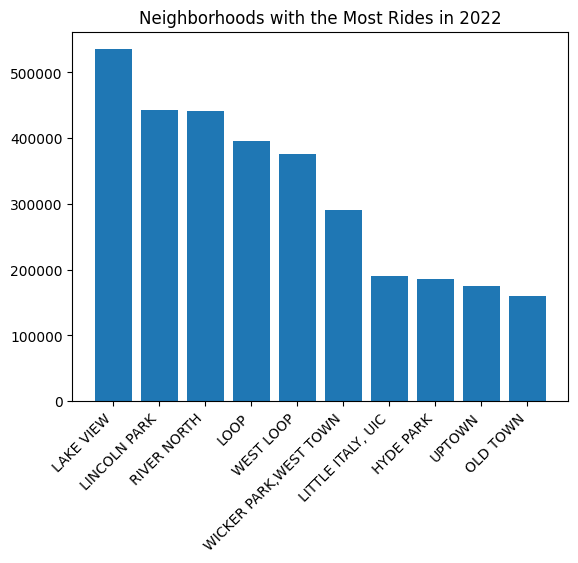

In [62]:
plt.bar(neighborhood_most_index, neighborhood_most_rides)
plt.xticks(rotation=45, ha='right')
plt.title('Neighborhoods with the Most Rides in 2022')
plt.show()

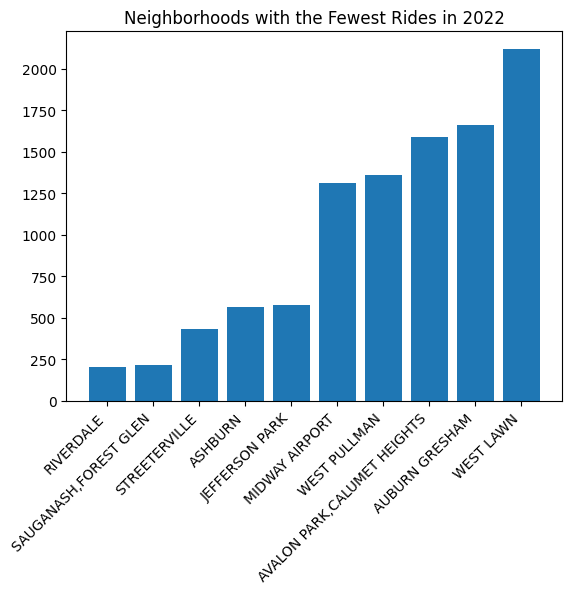

In [63]:
plt.bar(neighborhood_fewest_index, neighborhood_fewest_rides)
plt.xticks(rotation=45, ha='right')
plt.title('Neighborhoods with the Fewest Rides in 2022')
plt.show()

## Do More Stations Result in More Rides?

The output below shows a slightly positive relationship between the number of stations in a neighborhood and the number of rides taken. However, there are some neighborhoods, shown in the red box, that have very low ridership despite having a large number of stations.

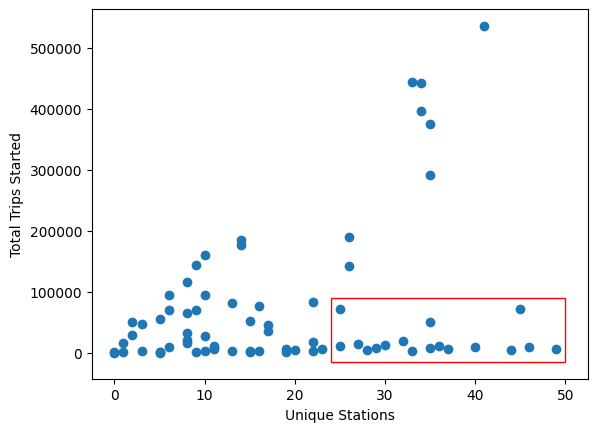

In [64]:
plt.scatter(all_neighborhoods.unique_station_count, all_neighborhoods.ride_start_count)
plt.xlabel('Unique Stations')
plt.ylabel('Total Trips Started')

rectangle = plt.Rectangle((24, -15000), width=26, height=105000, edgecolor='red', fill=False)
ax=plt.gca()
ax.add_patch(rectangle)

Below are the neighborhoods shown in the red box above

In [65]:
all_neighborhoods.loc[(all_neighborhoods['ride_start_count'] < 100000) & (all_neighborhoods['unique_station_count'] > 23)]

,ride_start_count,ride_end_count,unique_station_count,flow_diff,flow_ratio
neighborhood,,,,,
BRONZEVILLE,72051.0,72174.0,25.0,123.0,1.001707
LITTLE VILLAGE,12342.0,12684.0,30.0,342.0,1.027710
"SOUTH SHORE, GRAND CROSSING",10639.0,10869.0,36.0,230.0,1.021619
BACK OF THE YARDS,8022.0,8195.0,35.0,173.0,1.021566
WEST RIDGE,15026.0,16012.0,27.0,986.0,1.065620
"BRIGHTON PARK,MCKINLEY PARK",11737.0,9962.0,25.0,-1775.0,0.848769
"BELMONT CRAGIN,HERMOSA",19310.0,19358.0,32.0,48.0,1.002486
"IRVING PARK,AVONDALE",70954.0,72180.0,45.0,1226.0,1.017279
HUMBOLDT PARK,50681.0,52130.0,35.0,1449.0,1.028591


Ultimately, further investigation would be needed to understand why ridership is lower in these areas. These may be neighbrhoods where divvy can do a better job promoting itself. These also may just be neighborhoods where the city of Chicago should improve bikeability. It's worth looking into to determine how divvy can expand its ridership across the city and improve biking conditions for everyone

## Additional: Prepping Data for Tableau

In addition to the brief analysis above, I will also be using this data to create a Tableau dashboard to look at overall chicago biking data

That dashboard can be found here:


In [66]:
#Attempting to shrink our DF a bit in order to fit within Tableau Public's limits
#I am additionally removing rides less than 60 seconds as well as the ride_id, station_id's, lat and long columns in order to reduce the soze of the DF

divvy_df = df.copy()
divvy_df = divvy_df.loc[divvy_df['ride_length_seconds'] > 60][['ride_id','rideable_type', 'started_at', 'ended_at', 'ride_length_seconds', 'start_station_name', 'end_station_name', 
                                      'member_casual', 'ride_dist', 'start_neighborhood', 'end_neighborhood']]
divvy_df

,ride_id,rideable_type,started_at,ended_at,ride_length_seconds,start_station_name,end_station_name,member_casual,ride_dist,start_neighborhood,end_neighborhood
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,177.0,Glenwood Ave & Touhy Ave,Clark St & Touhy Ave,casual,0.434679,ROGERS PARK,ROGERS PARK
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,261.0,Glenwood Ave & Touhy Ave,Clark St & Touhy Ave,casual,0.431432,ROGERS PARK,ROGERS PARK
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,261.0,Sheffield Ave & Fullerton Ave,Greenview Ave & Fullerton Ave,member,0.621889,SHEFFIELD & DEPAUL,LINCOLN PARK
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,896.0,Clark St & Bryn Mawr Ave,Paulina St & Montrose Ave,casual,1.530302,EDGEWATER,LAKE VIEW
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,362.0,Michigan Ave & Jackson Blvd,State St & Randolph St,member,0.506131,GRANT PARK,LOOP
...,...,...,...,...,...,...,...,...,...,...,...
5657643,43ABEE85B6E15DCA,classic_bike,2022-12-05 06:51:04,2022-12-05 06:54:48,224.0,Sangamon St & Washington Blvd,Peoria St & Jackson Blvd,member,0.389174,WEST LOOP,WEST LOOP
5657644,F041C89A3D1F0270,electric_bike,2022-12-14 17:06:28,2022-12-14 17:19:27,779.0,Bernard St & Elston Ave,Seeley Ave & Roscoe St,member,1.825302,"IRVING PARK,AVONDALE",NORTH CENTER
5657645,A2BECB88430BE156,classic_bike,2022-12-08 16:27:47,2022-12-08 16:32:20,273.0,Wacker Dr & Washington St,Green St & Madison St,member,0.624739,LOOP,WEST LOOP
5657646,37B392960E566F58,classic_bike,2022-12-28 09:37:38,2022-12-28 09:41:34,236.0,Sangamon St & Washington Blvd,Peoria St & Jackson Blvd,member,0.389174,WEST LOOP,WEST LOOP


In [67]:
divvy_df.to_csv('divvy_df.csv')

In [68]:
df.loc[df['start_neighborhood']=='WEST LOOP']['start_station_name'].value_counts()

start_station_name
Clinton St & Madison St            25051
Clinton St & Washington Blvd       23882
Green St & Madison St              21494
Canal St & Adams St                20907
Clinton St & Jackson Blvd          17801
Clinton St & Lake St               17256
Peoria St & Jackson Blvd           16968
Canal St & Madison St              13639
Aberdeen St & Jackson Blvd         11854
Canal St & Monroe St               11768
Desplaines St & Jackson Blvd       11381
Desplaines St & Randolph St        10764
Aberdeen St & Randolph St          10587
Canal St & Jackson Blvd            10534
Green St & Randolph St*            10196
Aberdeen St & Monroe St             9627
Morgan St & Lake St                 9022
Sangamon St & Washington Blvd       8913
Clinton St & Roosevelt Rd           8430
Jefferson St & Monroe St            8214
Sangamon St & Lake St               7989
Ada St & Washington Blvd            7980
Canal St & Taylor St                6804
Loomis St & Jackson Blvd            61